# **Lecture 16 - Some examples solving ML problems with MLPs** #

# CONTRIBUTORS #

This in-class exercise is to be done in pairs. Add the names of the two students in this text block.


In [200]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms # This is a library holding a bunch of datasets
from torch.utils.data import DataLoader

# Workflow for today

Today we are going to step through some very simple problems we can train with an MLP, and different optimization problems that our cookbook can be applied to. For many of these problems, MLPs are an old-fashioned way of approaching them. But they're simple to set up and will let us focus on how to go through our 5 step cookbook for training a pytorch model:

1. Load data in
2. Build PyTorch class of hypothesized model form (in this case an MLP)
3. Set up an optimizer
4. Train model
5. Visualize results

Now that we are moving toward "real life" problems, we will learn about classification. So far we have looked at fitting pairs of input-output data $(x_i,y_i)$ that correspond to real numbers. Many machine learning tasks correspond to classification problems, where the input is an arbitrary type of data (text, images, etc) and the output is a list of categories. For example, someone may show you images of pets, and you can train a network to identify them as either a cat or a dog ( $y_i \in \left\{cat,dog\right\}$). In *sentiment analysis*, you might take social media posts and identify them as $y_i \in \left\{angry,excited, sad\right\}$. In engineering contexts, this is very useful for *anomaly detection* - you can take measurements of widgets manufactured on an assembly line, and predict whether $y_i \in \left\{\text{defected}, \text{defect-free}\right\}$. 

Today will really be an exercise in understanding different sorts of loss functions for different tasks. We'll solve the following 3 examples today:
1. A warmup, just minimizing a simple function and refreshing our 5-step cookbook.
2. A classifier to identify numbers as positive or negative
3. A classifier to identify species of three different variations of iris flowers from measurements.

## Example 1. Getting trapped in local minima ##

First we will generate a simple function that has two local minima, but with one minima smaller than the other. The code block below is something I cooked up to find a polynomial with the right shape.

In [201]:
# Define the five data points
xx = np.array([0.0,0.25,0.5,0.75,1.0])
yy = np.array([2.,0.5,0.6,-1.0,2.])

# Construct the Vandermonde matrix for degree 5
V = np.vander(xx, 6)  # 6 columns for degree 5

# Solve for the coefficients using least squares
coefficients = np.linalg.lstsq(V, yy,rcond=1e-12)[0]

# Define the polynomial function
def quintic_poly(x_val):
    return coefficients[0]*x_val**5 + coefficients[1]*x_val**4 + coefficients[2]*x_val**3 + \
           coefficients[3]*x_val**2 + coefficients[4]*x_val + coefficients[5]


**Step 1. Load data in.**

We will use this function to build up a dataset of $(x_i,y_i)$ pairs and stick them into a pytorch tensor. We will also visualize this to make sure we understand what the data looks like.

In [ ]:
# Generate data
Ndata = 100
x = np.linspace(0, 1, Ndata)
y = quintic_poly(x)

# Put into pytorch tensors
x_data = torch.tensor(x,dtype=torch.float32)
y_data = torch.tensor(y,dtype=torch.float32)

# Plot the data
plt.plot(x_data.detach().numpy(), y_data.detach().numpy(), label='Data')


For this dataset, we can see there are two minima near x = 0.2 and 0.8. If we initialize our guess near the 0.2, we should expect to get trapped there. We will show that by minibatching, we can escape the local minima and pop over into the global minimizer at x = 0.8.

**Step 2: Build PyTorch class of hypothesized model form**

For this problem, we want to solve the optimization problem:
$$\underset{x}{\min}\quad y(x)$$

To do this, we will need to build a pytorch model that outputs the function $y(x)$, where $x$ is a trainable parameter. The following code will do just that. To do this, I copied and pasted from the example code we've used before and tweaked the parameters to refer to x and rewrote the forward pass (we will always do something like this).

In [206]:
class twoMinimaPolynomialModel(nn.Module):
    def __init__(self,initialGuess):
        super(twoMinimaPolynomialModel, self).__init__()
        self.x_min = nn.parameter.Parameter(torch.tensor(initialGuess,dtype=torch.float32), requires_grad=True)

    def forward(self, x):
        return quintic_poly(self.x_min)

**Step 3. Set up optimizer**

Next we will initialize our model and then choose an optimizer and learning rate. I've set it up so that you can pass your initial guess as a parameter to make it easy later to explore how changing this helps.

In [207]:
initialGuess = 0.0
model = twoMinimaPolynomialModel(initialGuess)
optimizer = optim.Adam(model.parameters(), lr=0.01)

**Step 4. Train model**
Here we will set up our training loop. For this problem we won't need many steps. 

In [ ]:
num_epochs = 30
guesses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_out = model(x_data)
    loss = y_out # Define the thing we want to minimize here
    loss.backward()
    optimizer.step()

    if epoch % 1 == 0:
        print('Epoch:', epoch, 'Loss:', loss.item(), 'x_min:', model.x_min.item())
        guesses.append(model.x_min.item()) #  Store the intermediate guesses so we can plot them later

**Step 5. Visualize results**

In [ ]:
plt.plot(x,y)
plt.scatter(guesses, quintic_poly(np.stack(guesses)), color='red')

**Your turn.** Play with some different choices of initial guess. What happens if you start at x = 0? x = 1? x = 0.5?

# Introducing classification #

We call the problem where we want to map an arbitrary input to a class (e.g. a cat or a dog) as classification. The way we set this up is we output the *probability* that an input belongs to a given class. We won't assume anyone has done probability before, so we'll introduce the bare bones of probability that we need in order to set up this problem.

*Def: Discrete random variable.* An event $A$ that takes on one of a discrete number of possible values (i.e. $A \in \left\{A_1,...,A_n\right\})

*Example:* When you roll a six-sided die, if we define $A$ as number rolled, then $A \in \left\{1,2,3,4,5,6\right\}$.

*Example:* When you flip a coin, if we define $A$ as which side landed face up, then $A \in \left\{\text{heads}, \text{tails}\right\}$.

*Def: Discrete probability distribution.* If the event is measured over a very large number of independent experiments, the fraction of the total number of experiments associated with the outcome is defined as the probability. We write the probability as $p(A = A_i)$ or $p(A_i)$ for short, and we require:
1. $0 \leq p(A_i) \leq 1$
2. $\underset{i}{\sum} p(A_i) = 1$

*Example:* For a fair 6-sided die, we would have:
$$p(A = 1) = p(A = 2) = p(A = 3) = p(A = 4) = p(A = 5) = p(A = 6) = \frac16$$
*Example:* For a fair coin, we would have:
$$p(A = \text{heads}) = p(A = \text{tails}) = \frac12$$

If we want to measure the difference between two probability distributions, we can define many different kinds of loss functions. The idea is that we want to define something to steer a our probability predictions toward what our data says they should be.

One choice is called the **categorical cross-entropy loss**. The name may sound complicated, but its just a number that is big when two distributions are different, and zero when they are the same. So if we minimize it, it will steer one distribution toward a target distribution.

*Def:* the cross-entropy loss is defined as

$$ \text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \cdot \log(p_{i,c}) $$

( N ): Number of samples
( C ): Number of classes
( $y_{i,c}$ ): Binary indicator (0 or 1) if class label ( c ) is the correct classification for observation ( i )
( $p_{i,c}$ ): Predicted probability of observation ( i ) being in class ( c )

This will be a little intimidating at first, but we will work through some simple examples. We need this probability, because often it will be a bit fuzzy whether something should be defined as a cat or a dog. For example, in the following image, a human would label the red box 100% cat, and the green box 100% dog.

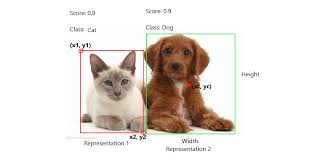

But for the following image, maybe you would want to label it 50%/50%.

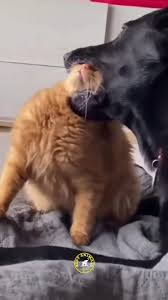

# Example 2: Classifying real numbers as positive or negative #

In our next example, we will generate a very simple dataset of random numbers from the interval [-1,1] and train a neural network to identify them as either positive or negative. Of course, this is a silly way to solve this problem. But it will let us focus on how to set up a classification problem when it is crystal clear what should be assigned to what class.

**Step 1. Load data in.**
We will generate N random numbers and define them as belonging to category 0 if they are negative and 1 if they are positive.

In [210]:
Ndata = 10
x_list = []
y_list = []
for i in range(Ndata):
    x = np.random.uniform(-1,1)
    if x < 0:
        y = 0
    if x >= 0:
        y = 1
    x_list.append(x)
    y_list.append(y)

# Put into pytorch tensors
x_data = torch.tensor(x_list,dtype=torch.float32)
y_data = torch.tensor(y_list,dtype=torch.float32)

# Generate one-hot encoding of y_data
y_data_onehot = torch.zeros(Ndata,2)
y_data_onehot[torch.arange(Ndata),y_data.long()] = 1

What was this one-hot encoding step? This tells us the probability that the data belongs to either class. Of course - for a given number, we know with 100% certainty whether it is positive or negative. In the code block below, print out x_data alongside y_data_onehot for each example, so we can see what each number is being mapped to. These will serve as our examples for the probability that we should be targeting.

In [ ]:
for i in range(Ndata):
    print(x_data[i],y_data_onehot[i,:])

**Step 2: Build PyTorch class of hypothesized model form**

Our next model is going to look much more differently than those we've made before. We discussed in class on Monday that neural networks are *universal function approximators*. That means they can (theoretically) map any kind of input to any kind of output. For this simple example, we are going to build an MLP which maps from a real number to a probability distribution on the event $p(A(x) = \text{x is a negative number})$.

To do this, I've copied and pasted the code from above:

In [212]:
class ClassificationMLP(nn.Module):
    def __init__(self):
        super(ClassificationMLP, self).__init__()
        self.Nneurons = 10
        self.hidden = nn.Linear(1, self.Nneurons)
        self.relu = nn.ReLU()
        self.output = nn.Linear(self.Nneurons, 2) # two output neurons
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.output(self.relu(self.hidden(x))))

Let's talk through this piece. The first four lines in the constructor (self.Nneurons through self.output) were copied directly from the other MLP examples we've played with so far. We've changed it though so that the output layer outputs 2 neurons. Let's call these $z_1$ and $z_2$. These will just be some real number.

We take those two numbers and feed them into what's called a softmax function. The mathematical definition of a softmax is as follows:
$$ \sigma_i(\mathbf{z}) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}} \quad \text{for} \quad i = 1, 2, \dots, C $$

Components:
* $ \sigma_i(\mathbf{z}) $: The probability of the (i)-th class.
* $ z_i $: The raw score (logit) for the (i)-th class.
* $ C $: Total number of classes.

The way to think about a softmax, is that it takes a raw score (or logit, in machine learning language) output from an MLP, and converts it into a probability distribution. For a function to output a probability, it has to be (1) positive for each class and (2) sum to one. We can easily check that:

1. The numerator in the definition is an exponential of something. Exponentials are always positive.
2. If you sum the numerator over i, you will get the same expression as the denominator so they cancel to 1. 

That means that our model will take in a real number as an input, and spit out a probability distribution. It will be up to the training though to make that probability match reality - that's why we'll steer it with lots of examples of "good" input/output relationships.



**Step 3. Set up optimizer**

Here we can use an off the shelf choice for the cross entropy loss function.

In [213]:
#Initialize the model
model = ClassificationMLP()

# Define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

**Step 4. Train model**
We can take our usual training loop, and now we just need to feed it the inputs and outputs appropriately.

In [ ]:
num_epochs = 3000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_out = model(x_data.unsqueeze(1))
    loss = criterion(y_out, y_data.long())
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print('Epoch:', epoch, 'Loss:', loss.item())

**Step 5. Postprocess results**

What does it mean for a classification model to work well? We want to know whether the probabilities are accurate. To do that, lets plot a few examples so we can see how the predicted probabilities line up with the true probabilities.

In [ ]:
with torch.no_grad():
    y_out = model(x_data.unsqueeze(1))
    for i in range(10):
        print('(input number/predicted probability/true probability): ',x_data[i].detach().numpy(),y_out[i,:].detach().numpy(),y_data_onehot[i,:].detach().numpy())
    # y_pred = torch.argmax(y_out, dim=1)
    # print('Accuracy:', torch.sum(y_pred == y_data.long()).item() / Ndata)

That's pretty wild! It looks like it's perfectly recovered the correct probabilities. To interrogate this more carefully, we want to make sure that wew haven't overfit the model. That means that we want to check that the model isn't just matching the dataset perfectly, but that we're actually learning a function that can make predictions "in-between" datapoints. To check this, I'm going to make predictions on a very fine grid running between [-1,1].

In [ ]:
xtest = np.linspace(-1,1,1000)
xtest = torch.tensor(xtest,dtype=torch.float32)
y_out = model(xtest.unsqueeze(1))
plt.plot(xtest,y_out[:,0].detach().numpy(),label='Probability of class 0')
plt.plot(xtest,y_out[:,1].detach().numpy(),label='Probability of class 1')

# plot data points to help visualize overfitting
plt.scatter(x_data,y_data_onehot[:,0],label='Data points for class 0')
plt.scatter(x_data,y_data_onehot[:,1],label='Data points for class 1')
plt.legend()
plt.show()


What a perfect prediction would be, is something that sharply transitions exactly at x = 0 between 0% and 100% probability. Depending on your random collection of data, you are likely to see something that smoothly transitions not quite at x=0, which encodes the uncertainty in the dataset about where exactly the *class boundary* is between the two classes. To get a feel for this, do the following experiments:
1. Rerun these blocks of code a few times. What trends do you see? Can you reliably say something about what governs how wide the "fuzzy" boundary between positive and negative numbers are? About where it's centered?
2. Based on these observations, make a hypothesis about what will happen when you crank up the number of data in Step 1. Run the experiment, and include a plot below describing how much data you need to make a "good" prediction.

**Your turn:** Respond to the above question here.

# Example 3: a more scientifically relevant botany problem #

In his 1936 paper *The species problem in Iris*, the botanist Edgar Anderson picked flowers from three related species of the Iris flower and measured features of them - the sepal length, sepal width, petal length, and petal width. Two of the three species were collected in the Gaspe Peninsula "all from the same pasture, and picked on the same day and measured at the same time by the same person with the same apparatus".

Here are some pictures of the three species (from left to right: iris setosa, iris versicolor, iris virginica)

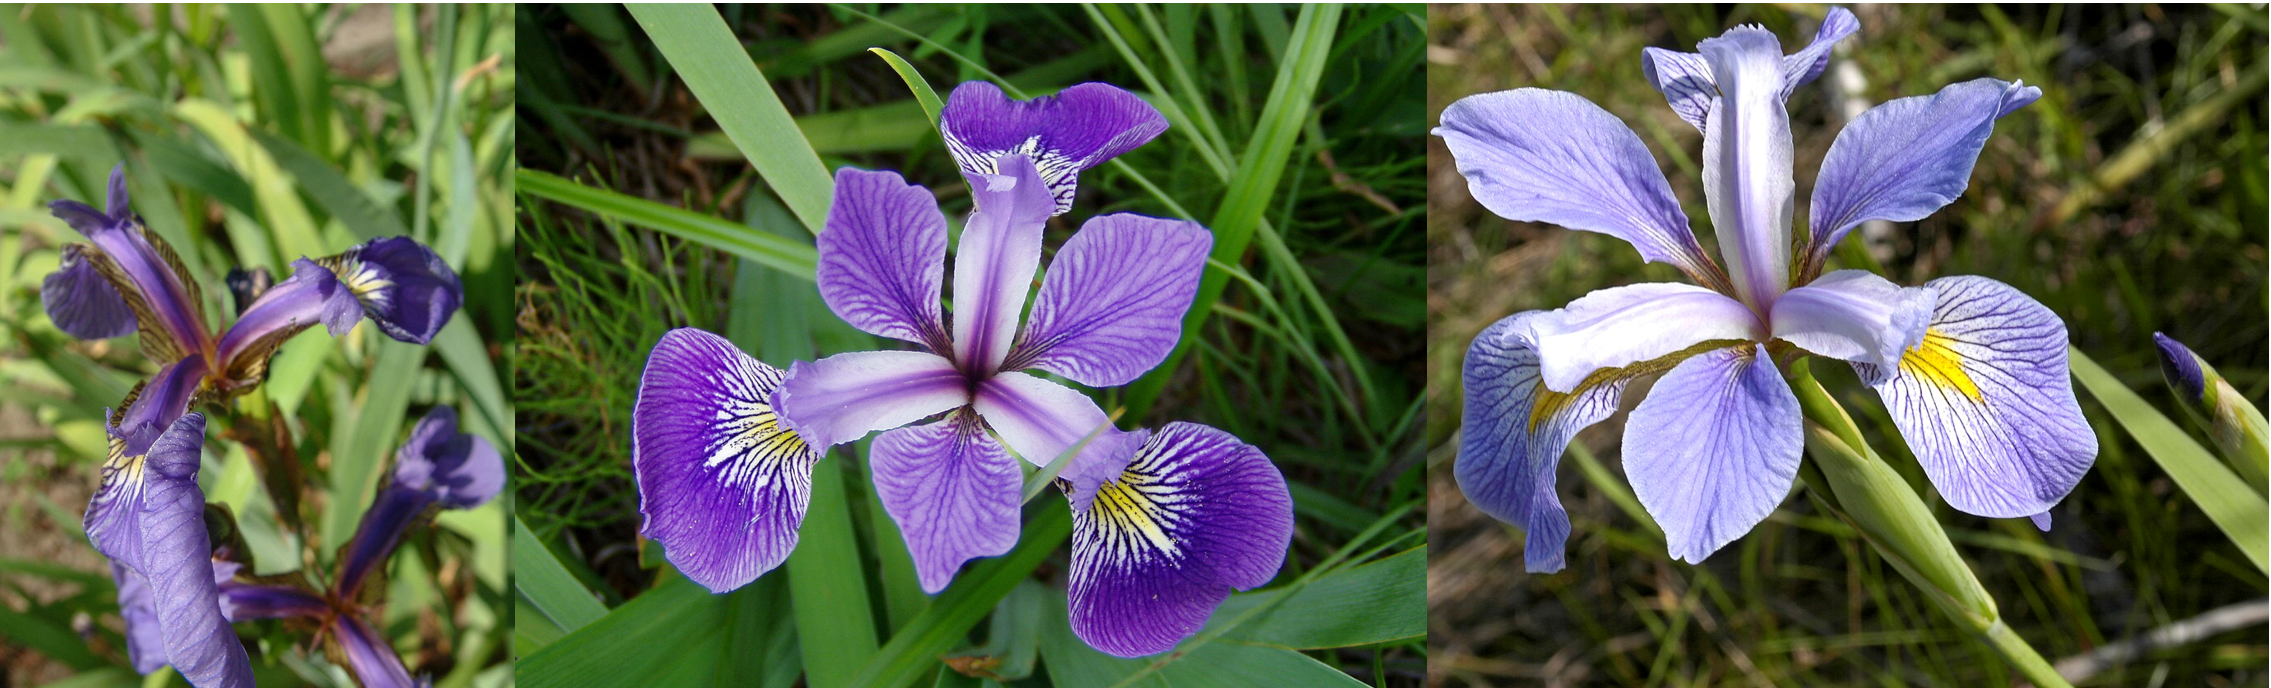

and here is a diagram explaining what a sepal and petal specifically refers to

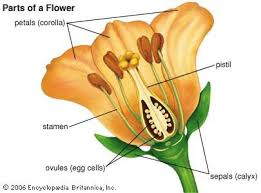

This is a common warmup dataset for people to learn how to build classifiers on. Many different python libraries (scikitlearn, pytorch, etc) have functions that let you load this dataset - it's a standard benchmark to test out different types of classification methods. The following block of code will load this dataset in. Don't worry about the inner workings - I copied this from the sklearn website. The important point is that you will be left with a list of measurements in X_flowers and a list of labels (corresponding to setosa, versicolor or virginica) in Y_flowers.

In [217]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
iris = load_iris()
X_flowers = iris.data  # Features
Y_flowers = iris.target  # Labels

# Standardize the features - scale everything to be O(1)
scaler = StandardScaler()
X_flowers = scaler.fit_transform(X_flowers)

Take a look at X_flowers.shape:

In [ ]:
print(X_flowers.shape)

We can see that we have 150 examples of sepal length, sepal width, petal length, and petal width for each flower. To make this simple to visualize in 2D, we will attempt to classify which type of flower we're looking at just from the petal length and petal width. That means we will have a network that takes as input petal length + width (two measurements) and outputs 3 probabilities (which of the three species we're looking at).

**Step 1. Load data in**

First we will downselect to the two desired features.

In [219]:
x_data = torch.tensor(X_flowers[:,-2:],dtype=torch.float32)
y_data = torch.tensor(Y_flowers,dtype=torch.float32)

#convert to one-hot encoding, just like example 2 above
y_data_onehot = torch.zeros(y_data.shape[0],3)
y_data_onehot[torch.arange(y_data.shape[0]),y_data.long()] = 1

To get a feel for the dataset, we can print the first few entries. Note that the dataset comes in chunks - the species are listed separately.

In [ ]:
for i in range(10):
    print(x_data[i],y_data_onehot[i])

And make a scatterplot to visualize how the two features map onto the different species.

In [ ]:
plt.scatter(x_data[Y_flowers==0][:,0],x_data[Y_flowers==0][:,1],label='Iris Setosa')
plt.scatter(x_data[Y_flowers==1][:,0],x_data[Y_flowers==1][:,1],label='Iris Versicolour')
plt.scatter(x_data[Y_flowers==2][:,0],x_data[Y_flowers==2][:,1],label='Iris Virginica')
plt.legend()
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()

In this dataset we can see a pretty clear distinction already - setosa is clearly set apart, while there is some overlap between virginica and versicolor. We will want to check that our classifier can recover this clear distinction.

**Step 2. Build PyTorch class of hypothesized model form**

We'll copy the class from example 2 and tweak it. It can be exactly the same, but now will take a dimension two input and output 3 different classes, instead of 1 and 2.

In [222]:
class Flower_ClassificationMLP(nn.Module):
    def __init__(self):
        super(Flower_ClassificationMLP, self).__init__()
        self.Nneurons = 10
        self.hidden = nn.Linear(2, self.Nneurons) # **two** input neurons
        self.relu = nn.ReLU()
        self.output = nn.Linear(self.Nneurons, 3) # **three** output neurons
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.output(self.relu(self.hidden(x))))

**Step 3. Set up optimizer**

We can copy the optimizer setup from example 2 without modification, other than pointing to the different model name.

In [225]:
#Initialize the model
model = Flower_ClassificationMLP()

# Define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

**Step 4. Train model**

Again - this is almost identical to our example 2. Just need to point to the flower data instead.

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_out = model(x_data)
    loss = criterion(y_out, y_data_onehot)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print('Epoch:', epoch, 'Loss:', loss.item())

**Step 5. Postprocess results**

What does it mean for a classification model to work well? We want to know whether the probabilities are accurate. To do that, lets plot a few examples so we can see how the predicted probabilities line up with the true probabilities.

In [ ]:
with torch.no_grad():
    y_out = model(x_data)
    for i in range(10):
        print()
        print(x_data[i].detach().numpy(),y_out[i,:].detach().numpy(),y_data_onehot[i,:].detach().numpy())

So it looks pretty good, at least for the first few examples. Let's try to visualize the decision boundary by plotting the output over the dataset.

In [ ]:
x_min, x_max = x_data[:, 0].min() - 0.2, x_data[:, 0].max() + 0.2
y_min, y_max = x_data[:, 1].min() - 0.2, x_data[:, 1].max() + 0.2

#generate a grid of points between min and max
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
X_grid = torch.stack([xx.flatten(), yy.flatten()], 1)

#calculate the model output for the grid
with torch.no_grad():
    y_out = model(X_grid)
    y_out = torch.argmax(y_out, dim=1)

#plot the decision boundary
plt.contourf(xx, yy, y_out.view(100, 100), alpha=0.5)
plt.scatter(x_data[Y_flowers==0][:,0],x_data[Y_flowers==0][:,1],label='Iris Setosa')
plt.scatter(x_data[Y_flowers==1][:,0],x_data[Y_flowers==1][:,1],label='Iris Versicolour')
plt.scatter(x_data[Y_flowers==2][:,0],x_data[Y_flowers==2][:,1],label='Iris Virginica')
plt.legend()
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()


To assess the accuracy of a model, we would look at the *classification accuracy*. This means we look at the percentage of the dataset that is correctly classified. We'll see below that the accuracy is pretty good! 98% of the plants can be correctly classified just by looking at the petal width and length.

In [ ]:
with torch.no_grad():
    y_out = model(x_data)
    y_pred = torch.argmax(y_out, dim=1)
    accuracy = (y_pred == y_data.long()).sum().item() / y_data.size(0)
    print('Classification Accuracy:', accuracy)

**Your turn.** Modify the above example to use all 4 features available in the dataset. Can you get better than 98% accuracy?

# Turning in assignments on Canvas #
In order to submit your assignment as a pair, you need to create a group on Canvas. This will enable you to both receive the same grade for one submission.

On Canvas, navigate to People > Groups > In-Class 16.
Find an empty group and add the names of both members of the pair.

Submit your work as both an ipynb and a pdf to Canvas.

Save the ipynb and upload from your hard drive. Also print a pdf file to ensure the graders can see you have completed the exercise, even if there are issues with the formatting in your jupyter notebook.

The student who did not submit should make sure that the group was created successfully by checking that they can also access the files on their Canvas page.